# Machine Learning Predictions for the 2018-19 All-NBA team

I set out wanting to predict this season's MVP but that was too difficult for a number of reasons. I looked through the Sci-Kit documentation and was particularly drawn to the Classification section. At first I thought maybe the MVP is really just a classification problem, but after further thought I decided that wasn't the case. When a Center is selected to be the MVP, he is expected to excel in different areas then a point guard. So the classification for a Point Guard MVP should theoretically be different from a Center MVP. From there, I decided that it should be possible to use a Classification model to predict the MVP for each position, which is EXACTLY what the All-NBA team is. The All-NBA team has high stakes -- making the team often earns a player millions of dollars in contract incentives.

**You must use pip to install basketball_reference_web_scraper otherwise none of this will work. Install it using the following command: pip install basketball_reference_web_scraper** 

Note: I originally had an issue installing it which was solved by running the command like this:
pip install basketball_reference_web_scraper --ignore-installed

**Please run each cell in order!! The first cell takes a while to run since it is retrieving a lot of data. Just wait for it to finish**


First, to get the data:

I added in some calculated stats like field goal percentage and points.

Also, if a player was moved midseason, I combined their totals from each team.

In [2]:
from basketball_reference_web_scraper import client
import collections
import copy
import pandas as pd

statsToAdd = ['games_played', 'games_started', 'minutes_played', 'made_field_goals', 'attempted_field_goals', 'made_three_point_field_goals', 'attempted_three_point_field_goals', 'made_free_throws', 'attempted_free_throws', 'offensive_rebounds', 'defensive_rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'personal_fouls']

statDict = {}
for year in range(2001, 2020):
    yearPlayers = client.players_season_totals(season_end_year=year)
    playerIdList = [player['slug'] for player in yearPlayers]
    tradedPlayersIdList = [playerId for playerId, count in collections.Counter(playerIdList).items() if count > 1]
    for tradedPlayerId in tradedPlayersIdList:
        playerStatsList = []
        toDelete = []
        totalPlayerStats = {'slug': '', 'name': '', 'positions': 0, 'age': 0, 'team': 0, 'games_played': 0, 'games_started': 0, 'minutes_played': 0, 'made_field_goals': 0, 'attempted_field_goals': 0, 'made_three_point_field_goals': 0, 'attempted_three_point_field_goals': 0, 'made_free_throws': 0, 'attempted_free_throws': 0, 'offensive_rebounds': 0, 'defensive_rebounds': 0, 'assists': 0, 'steals': 0, 'blocks': 0, 'turnovers': 0, 'personal_fouls': 0}
        for idx, player in enumerate(yearPlayers):
            if tradedPlayerId == player['slug']:
                playerStatsList.append(player)
                toDelete.append(idx)
        for i in toDelete:
            yearPlayers.pop(toDelete[0])
        for playerTeamStats in playerStatsList:
            if totalPlayerStats['slug'] == '':
                totalPlayerStats['slug'] = playerTeamStats['slug']
            if totalPlayerStats['name'] == '':
                totalPlayerStats['name'] = playerTeamStats['name']
            if totalPlayerStats['positions'] == 0:
                totalPlayerStats['positions'] = playerTeamStats['positions']
            if totalPlayerStats['age'] == 0:
                totalPlayerStats['age'] = playerTeamStats['age']
            if totalPlayerStats['team'] == 0:
                totalPlayerStats['team'] = playerTeamStats['team']
            for statName in statsToAdd:
                totalPlayerStats[statName] = totalPlayerStats[statName] + playerTeamStats[statName]
        yearPlayers.append(totalPlayerStats)
        for player in yearPlayers:
            #center = 1, forward = 2, guard = 3
             
            positionstring = str(player['positions'])
            #print(positionstring)

            if 'CENTER' in positionstring: # 8, -1
                 player['positions'] = 1
            elif 'FORWARD' in positionstring:
                player['positions'] = 2
            elif 'GUARD' in positionstring:
                player['positions'] = 3
            
            if(player['attempted_field_goals'] != 0):
                player['effective_field_goal_percentage'] = (player['made_field_goals'] + (.5 * player['made_three_point_field_goals'])) / player['attempted_field_goals']
            else:
                player['effective_field_goal_percentage'] = 0
            player['total_points'] = (player['made_three_point_field_goals'] * 3) + ((player['made_field_goals'] - player['made_three_point_field_goals']) * 2) + (player['made_free_throws'])
            if(player['attempted_free_throws'] != 0):
                player['free_throw_percentage'] = player['made_free_throws'] / player['attempted_free_throws']
            else:
                player['free_throw_percentage'] = 0
    statDict[year] = yearPlayers


In [4]:
for year in range(2001, 2020):
    for game in client.season_schedule(season_end_year=year):
        for player in statDict[year]:
            if "team_games_played" in player and player["team_games_played"] >= 82:
                break
            if player["team"] == game["home_team"] or player["team"] == game["away_team"]:
                if "team_games_played" in player:
                    player["team_games_played"] += 1
                else:
                    player["team_games_played"] = 1
            if game["home_team_score"] > game["away_team_score"]:
                if player["team"] == game["home_team"]:
                    if "wins" in player:
                        player["wins"] += 1
                    else:
                        player["wins"] = 1
            else:
                if player["team"] == game["away_team"]:
                    if "wins" in player:
                        player["wins"] += 1
                    else:
                        player["wins"] = 1

In [5]:
currentStatDict = copy.deepcopy(statDict[2019])
statDict.pop(2019) #keep in statDict or remove data from statdict 
print(currentStatDict)

[{'slug': 'abrinal01', 'name': 'Álex Abrines', 'positions': 3, 'age': 25, 'team': <Team.OKLAHOMA_CITY_THUNDER: 'OKLAHOMA CITY THUNDER'>, 'games_played': 31, 'games_started': 2, 'minutes_played': 588, 'made_field_goals': 56, 'attempted_field_goals': 157, 'made_three_point_field_goals': 41, 'attempted_three_point_field_goals': 127, 'made_free_throws': 12, 'attempted_free_throws': 13, 'offensive_rebounds': 5, 'defensive_rebounds': 43, 'assists': 20, 'steals': 17, 'blocks': 6, 'turnovers': 14, 'personal_fouls': 53, 'points': 165, 'effective_field_goal_percentage': 0.4872611464968153, 'total_points': 165, 'free_throw_percentage': 0.9230769230769231, 'team_games_played': 82, 'wins': 49}, {'slug': 'acyqu01', 'name': 'Quincy Acy', 'positions': 2, 'age': 28, 'team': <Team.PHOENIX_SUNS: 'PHOENIX SUNS'>, 'games_played': 10, 'games_started': 0, 'minutes_played': 123, 'made_field_goals': 4, 'attempted_field_goals': 18, 'made_three_point_field_goals': 2, 'attempted_three_point_field_goals': 15, 'mad

Using beautiful soup to get a nice clean list of the all-nba players since 2000.

In [6]:
from bs4 import BeautifulSoup
import urllib.request
import collections
import re
import bs4
import lxml

url = 'https://www.basketball-reference.com/awards/all_league.html'

soup = BeautifulSoup()

textList = []
allNbaTeamDict = {}
with urllib.request.urlopen(url) as ef:
    soup = BeautifulSoup(ef)
    textList = soup.find('table').get_text().splitlines()[15:]

    for line in textList:
        year = line[:7]
        formattedYear = year[:2] + year[5:]
        if formattedYear == '1900':
            formattedYear = '2001'
        if year == '1999-00':
            break
        if formattedYear not in allNbaTeamDict:
            allNbaTeamDict[formattedYear] = []
        wordList = line[13:].split()
        if len(wordList) == 0:
            continue
        playerTuple = (wordList[2][0],"%s %s" % (wordList[0], wordList[1]))
        allNbaTeamDict[formattedYear].append(playerTuple)
        playerTuple = (wordList[4][0],"%s %s" % (wordList[2][1:], wordList[3]))
        allNbaTeamDict[formattedYear].append(playerTuple)
        playerTuple = (wordList[6][0],"%s %s" % (wordList[4][1:], wordList[5]))
        allNbaTeamDict[formattedYear].append(playerTuple)
        playerTuple = (wordList[8][0],"%s %s" % (wordList[6][1:], wordList[7]))
        allNbaTeamDict[formattedYear].append(playerTuple)
        playerTuple = (wordList[10][0],"%s %s" % (wordList[8][1:], wordList[9]))
        allNbaTeamDict[formattedYear].append(playerTuple)
    allNbaTeamDict.pop('')
print(allNbaTeamDict)

{'2019': [('C', 'Nikola Jokić'), ('F', 'Giannis Antetokounmpo'), ('F', 'Paul George'), ('G', 'James Harden'), ('G', 'Stephen Curry'), ('C', 'Joel Embiid'), ('F', 'Kevin Durant'), ('F', 'Kawhi Leonard'), ('G', 'Damian Lillard'), ('G', 'Kyrie Irving'), ('C', 'Rudy Gobert'), ('F', 'LeBron James'), ('F', 'Blake Griffin'), ('G', 'Kemba Walker'), ('G', 'Russell Westbrook')], '2018': [('C', 'Anthony Davis'), ('F', 'LeBron James'), ('F', 'Kevin Durant'), ('G', 'Damian Lillard'), ('G', 'James Harden'), ('C', 'Joel Embiid'), ('F', 'Giannis Antetokounmpo'), ('F', 'LaMarcus Aldridge'), ('G', 'Russell Westbrook'), ('G', 'DeMar DeRozan'), ('C', 'Karl-Anthony Towns'), ('F', 'Jimmy Butler'), ('F', 'Paul George'), ('G', 'Stephen Curry'), ('G', 'Victor Oladipo')], '2017': [('C', 'Anthony Davis'), ('F', 'LeBron James'), ('F', 'Kawhi Leonard'), ('G', 'James Harden'), ('G', 'Russell Westbrook'), ('C', 'Rudy Gobert'), ('F', 'Giannis Antetokounmpo'), ('F', 'Kevin Durant'), ('G', 'Stephen Curry'), ('G', 'Isai

Adding the all_nba_type back into our stat dictionary:

In [7]:
relevantCenterData = []
relevantForwardData = []
relevantGuardData = []

for year in allNbaTeamDict:
    for position, playerName in allNbaTeamDict[str(year)]:
        if year != '2019': #exclude 2019 data for allnbateam 
            if position == 'C':
                for player in statDict[int(year)]:
                    if player['name'] == playerName:
                        relevantCenterData.append(player)
            elif position == 'F':
                for player in statDict[int(year)]:
                    if player['name'] == playerName:
                        relevantForwardData.append(player)
            elif position == 'G':
                for player in statDict[int(year)]:
                    if player['name'] == playerName:
                        relevantGuardData.append(player)

print(allNbaTeamDict)

{'2019': [('C', 'Nikola Jokić'), ('F', 'Giannis Antetokounmpo'), ('F', 'Paul George'), ('G', 'James Harden'), ('G', 'Stephen Curry'), ('C', 'Joel Embiid'), ('F', 'Kevin Durant'), ('F', 'Kawhi Leonard'), ('G', 'Damian Lillard'), ('G', 'Kyrie Irving'), ('C', 'Rudy Gobert'), ('F', 'LeBron James'), ('F', 'Blake Griffin'), ('G', 'Kemba Walker'), ('G', 'Russell Westbrook')], '2018': [('C', 'Anthony Davis'), ('F', 'LeBron James'), ('F', 'Kevin Durant'), ('G', 'Damian Lillard'), ('G', 'James Harden'), ('C', 'Joel Embiid'), ('F', 'Giannis Antetokounmpo'), ('F', 'LaMarcus Aldridge'), ('G', 'Russell Westbrook'), ('G', 'DeMar DeRozan'), ('C', 'Karl-Anthony Towns'), ('F', 'Jimmy Butler'), ('F', 'Paul George'), ('G', 'Stephen Curry'), ('G', 'Victor Oladipo')], '2017': [('C', 'Anthony Davis'), ('F', 'LeBron James'), ('F', 'Kawhi Leonard'), ('G', 'James Harden'), ('G', 'Russell Westbrook'), ('C', 'Rudy Gobert'), ('F', 'Giannis Antetokounmpo'), ('F', 'Kevin Durant'), ('G', 'Stephen Curry'), ('G', 'Isai

In [8]:
# 1 = All-NBA center, 2 = All-NBA forward, 3 = All-NBA guard, 0 = regular player
for playerSeason in relevantCenterData:
    for year in statDict:
        for player in statDict[int(year)]:
            if player == playerSeason:
                player['all_nba_type'] = 1
for playerSeason in relevantForwardData:
    for year in statDict:
        for player in statDict[int(year)]:
            if player == playerSeason:
                player['all_nba_type'] = 2
for playerSeason in relevantGuardData:
    for year in statDict:
        for player in statDict[int(year)]:
            if player == playerSeason:
                player['all_nba_type'] = 3
flattenedStats = []
for year in statDict:
        for player in statDict[int(year)]:
            if 'all_nba_type' not in player:
                player['all_nba_type'] = 0
            flattenedStats.append(player) #add all players to flattenedstats

historicalDf = pd.DataFrame.from_dict(flattenedStats) #df of all players with All NBA team type
currentDf = pd.DataFrame.from_dict(currentStatDict) #df of current year to be looked at 
historicalDf.describe() 

,positions,age,games_played,games_started,minutes_played,made_field_goals,attempted_field_goals,made_three_point_field_goals,attempted_three_point_field_goals,made_free_throws,...,blocks,turnovers,personal_fouls,points,effective_field_goal_percentage,total_points,free_throw_percentage,team_games_played,wins,all_nba_type
count,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,...,8344.000000,8344.000000,8344.000000,7362.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000
mean,2.189238,26.686002,53.522052,26.048658,1259.842402,192.831735,426.370446,35.304171,99.046860,95.004674,...,25.517378,72.191755,109.569271,533.053111,0.471996,515.972315,0.700815,80.320829,39.930010,0.049257
std,0.755672,4.326196,24.918734,29.207754,906.613031,172.890404,372.372982,47.970925,126.569228,106.555690,...,34.153080,62.724687,73.213470,481.335014,0.098067,471.909631,0.192948,2.713720,12.425046,0.340406
min,1.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66.000000,7.000000,0.000000
25%,2.000000,23.000000,34.000000,1.000000,418.000000,48.000000,113.000000,0.000000,2.000000,18.000000,...,4.000000,21.000000,44.000000,131.000000,0.441176,123.000000,0.645161,81.000000,31.000000,0.000000
50%,2.000000,26.000000,61.000000,11.000000,1192.500000,150.000000,340.000000,11.000000,37.000000,59.000000,...,13.000000,58.000000,108.000000,421.000000,0.481608,397.000000,0.750000,81.000000,41.000000,0.000000
75%,3.000000,30.000000,75.000000,52.000000,1998.000000,294.250000,649.250000,58.000000,168.000000,134.000000,...,32.000000,107.000000,165.000000,813.000000,0.517550,784.000000,0.815094,81.000000,49.000000,0.000000
max,3.000000,44.000000,85.000000,83.000000,3485.000000,978.000000,2173.000000,402.000000,886.000000,756.000000,...,307.000000,464.000000,344.000000,2832.000000,1.500000,2832.000000,1.000000,82.000000,72.000000,3.000000


In [9]:
currentDf.describe()

,positions,age,games_played,games_started,minutes_played,made_field_goals,attempted_field_goals,made_three_point_field_goals,attempted_three_point_field_goals,made_free_throws,...,steals,blocks,turnovers,personal_fouls,points,effective_field_goal_percentage,total_points,free_throw_percentage,team_games_played,wins
count,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,...,530.000000,530.000000,530.000000,530.000000,444.00000,530.000000,530.000000,530.000000,530.000000,530.000000
mean,2.275472,25.896226,49.247170,23.207547,1121.618868,190.683019,414.071698,52.745283,148.569811,82.064151,...,35.432075,22.990566,62.816981,97.028302,528.63964,0.500298,516.175472,0.696771,80.616981,39.807547
std,0.750275,4.190477,26.048763,27.988087,838.657750,178.203049,376.879279,60.072619,159.609471,97.904875,...,32.162749,28.992827,61.375310,69.566638,513.12986,0.119148,490.433458,0.214882,0.565631,11.875725
min,1.000000,19.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,80.000000,16.000000
25%,2.000000,23.000000,27.000000,0.000000,323.500000,43.250000,100.250000,4.000000,16.000000,14.250000,...,9.000000,4.000000,14.250000,32.250000,107.75000,0.471813,115.000000,0.651580,80.000000,32.000000
50%,2.000000,25.000000,56.000000,8.000000,1069.000000,157.000000,335.000000,33.000000,98.000000,50.000000,...,28.000000,13.000000,47.000000,95.000000,416.50000,0.511156,419.000000,0.750000,81.000000,39.000000
75%,3.000000,29.000000,73.000000,43.750000,1836.500000,283.500000,618.250000,81.000000,226.500000,112.000000,...,54.000000,31.000000,91.750000,149.750000,812.00000,0.553553,759.500000,0.818182,81.000000,49.000000
max,3.000000,42.000000,82.000000,82.000000,3028.000000,843.000000,1909.000000,378.000000,1028.000000,754.000000,...,170.000000,199.000000,387.000000,292.000000,2818.00000,1.500000,2818.000000,1.000000,82.000000,60.000000


Now I have all of the All-NBA players since year 1999-2000 season and their stats, along with whether they made an All-NBA team or not, and which team they made. Now to select relevant statistic:

In [10]:
#extract relevant stats of historical data
relevantStatsHistoricalDf = historicalDf[['wins', 'positions','free_throw_percentage', 'turnovers', 'games_played', 'games_started', 'minutes_played', 'made_field_goals','attempted_field_goals', 'made_three_point_field_goals', 'attempted_three_point_field_goals', 'made_free_throws', 'attempted_free_throws', 'assists', 'blocks', 'steals', 'total_points', 'offensive_rebounds', 'defensive_rebounds', 'effective_field_goal_percentage', 'all_nba_type']] 
#additional 'free_throw_percentage', 'turnovers', 'games_played', 'games_started', 'minutes_played', 'made_field_goals', 'attempted_field_goals', 'made_three_point_field_goals', 'attempted_three_point_field_goals', 'made_free_throws', 'attempted_free_throws'
relevantStatsHistoricalDf.head()

#add position data 

,wins,positions,free_throw_percentage,turnovers,games_played,games_started,minutes_played,made_field_goals,attempted_field_goals,made_three_point_field_goals,...,made_free_throws,attempted_free_throws,assists,blocks,steals,total_points,offensive_rebounds,defensive_rebounds,effective_field_goal_percentage,all_nba_type
0,23,3,0.758621,26,41,0,486,120,246,4,...,22,29,76,1,9,266,5,20,0.495935,0
1,40,3,0.583333,34,29,12,420,43,111,4,...,21,36,22,13,14,111,14,45,0.405405,0
2,22,2,0.834275,231,81,81,3241,604,1280,12,...,443,531,250,77,90,1663,175,560,0.476562,0
3,43,3,0.666667,25,26,0,227,18,56,4,...,12,18,36,0,16,52,0,25,0.357143,0
4,52,3,0.887755,204,82,82,3129,628,1309,202,...,348,392,374,20,124,1806,101,327,0.556914,0


In [11]:
#extract relevant stats of current data
relevantStatsCurrentDf = currentDf[['wins', 'positions','free_throw_percentage', 'turnovers', 'games_played', 'games_started', 'minutes_played', 'made_field_goals','attempted_field_goals', 'made_three_point_field_goals', 'attempted_three_point_field_goals', 'made_free_throws', 'attempted_free_throws', 'assists', 'blocks', 'steals', 'total_points', 'offensive_rebounds', 'defensive_rebounds', 'effective_field_goal_percentage']] 
relevantStatsCurrentDf.head()

#add position data

,wins,positions,free_throw_percentage,turnovers,games_played,games_started,minutes_played,made_field_goals,attempted_field_goals,made_three_point_field_goals,attempted_three_point_field_goals,made_free_throws,attempted_free_throws,assists,blocks,steals,total_points,offensive_rebounds,defensive_rebounds,effective_field_goal_percentage
0,49,3,0.923077,14,31,2,588,56,157,41,127,12,13,20,6,17,165,5,43,0.487261
1,19,2,0.700000,4,10,0,123,4,18,2,15,7,10,8,4,1,17,3,22,0.277778
2,29,3,0.777778,28,34,1,428,38,110,25,74,7,9,65,5,14,108,11,49,0.459091
3,47,1,0.500000,135,80,80,2669,481,809,0,2,146,292,124,76,117,1108,391,369,0.594561
4,39,1,0.734513,121,82,28,1913,280,486,3,15,166,226,184,65,71,729,165,432,0.579218


In [12]:
#train a neural network classifier from scikit learn 
#use relevantStatsHistoricalDf
#print(relevantStatsHistoricalDf)
#split the data into train and test to evaluate performance of the neural net 
from sklearn.model_selection import train_test_split
y_col = 'all_nba_type' #to be removed from original Df and stored as targets
x_cols = list(relevantStatsHistoricalDf.columns.values)
x_cols.remove(y_col)

x = relevantStatsHistoricalDf[x_cols].values #all column values of df excluding allnbatype
y = relevantStatsHistoricalDf[y_col].values #corresponding targets

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2)

print(X_train)
print(Y_train)


[[ 40.           2.           0.86010363 ...  37.         326.
    0.5157967 ]
 [ 48.           2.           0.76865672 ... 181.         333.
    0.44012605]
 [ 21.           2.           0.53030303 ...  56.         112.
    0.444     ]
 ...
 [ 42.           3.           0.4        ...   4.          45.
    0.44871795]
 [ 45.           2.           0.83333333 ...  50.          95.
    0.45038168]
 [ 40.           2.           0.64571429 ... 226.         385.
    0.49443561]]
[0 0 0 ... 0 0 0]


In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [40]:
#build and train the actual neural net 
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=800)
parameter_space = {
    'hidden_layer_sizes': [(50, 50, 50)], #also tested (10, 10, 10), (8), (10), (50), (50, 50), (50, 50, 50)
    'activation': ['tanh', 'relu'], #tanh seems better
    'solver': [ 'sgd'], #
    'alpha': [.0001], #.0001 best, also checked .0001 and .001
    'learning_rate_init': [.001], #.001 best learning rate so far
    'learning_rate': ['constant','adaptive'],
}

from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, Y_train)

print('Best parameters found:\n', clf.best_params_)

# mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10))
# mlp.fit(X_train, Y_train)


Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'solver': 'sgd'}


In [41]:
#performance of model 
predictions = clf.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(Y_test,predictions))
print(classification_report(Y_test,predictions))

train_score = clf.score(X_train, Y_train)
test_score = clf.score(X_test, Y_test)
print("train_score: ", train_score)
print("test_score: ", test_score)


[[1625    0    6    0]
 [   6    1    0    0]
 [   5    0   11    0]
 [   7    0    0    8]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1631
           1       1.00      0.14      0.25         7
           2       0.65      0.69      0.67        16
           3       1.00      0.53      0.70        15

    accuracy                           0.99      1669
   macro avg       0.91      0.59      0.65      1669
weighted avg       0.99      0.99      0.98      1669

train_score:  0.9887640449438202
test_score:  0.9856201318154584


In [42]:
#test 2019 data on model 
curr_cols = list(relevantStatsCurrentDf.columns.values)
curr_test = relevantStatsCurrentDf[x_cols].values
curr_test = scaler.transform(curr_test) #scale testing data

print(curr_test)

allnbateam = clf.predict(curr_test)
print(allnbateam)

[[ 7.37467694e-01  1.07750955e+00  1.14997952e+00 ... -8.59017678e-01
  -8.22200339e-01  1.62036178e-01]
 [-1.67328528e+00 -2.45347953e-01 -1.08494902e-05 ... -8.91011825e-01
  -9.66865070e-01 -1.96821647e+00]
 [-8.69700956e-01  1.07750955e+00  4.00943647e-01 ... -7.63035238e-01
  -7.80867558e-01 -1.24429155e-01]
 ...
 [ 1.38033515e+00  1.07750955e+00  4.81134547e-01 ...  1.48797947e-01
   2.45563157e-01  7.28887264e-02]
 [-8.69700956e-01 -1.56820545e+00  4.00943647e-01 ... -7.63035238e-01
  -1.02886424e+00  6.30547826e-01]
 [-2.26833496e-01 -1.56820545e+00  5.23684820e-01 ...  9.00660397e-01
   5.83114198e-01  8.95283709e-01]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0

In [43]:
#allnbateam predictions
print("Predicted team")
for player in range(len(allnbateam)):
    if allnbateam[player] == 1:
        print("center: ", currentDf.iloc[player]['name'])
    elif allnbateam[player] == 2:
        print("forward: ", currentDf.iloc[player]['name'])
    elif allnbateam[player] == 3: 
        print("guard: ", currentDf.iloc[player]['name'])

print("\n best prediction: 13 for 15, some positional misclassification")

Predicted team
forward:  Giannis Antetokounmpo
guard:  Stephen Curry
center:  Anthony Davis
forward:  Kevin Durant
center:  Joel Embiid
forward:  Paul George
center:  Rudy Gobert
guard:  James Harden
forward:  Nikola Jokić
forward:  Kawhi Leonard
guard:  Damian Lillard

 best prediction: 13 for 15, some positional misclassification


In [46]:
#0-none, 1-center, 2-forward, 3-guard 
import numpy as np

allprobs = clf.predict_proba(curr_test)
#add index as 5th column of matrix 
idx = range(0, allprobs.shape[0])
print(allprobs.shape)
idx = np.asarray(idx)
idx = np.reshape(idx, (530, 1))
allprobs = np.hstack((allprobs, idx))

allcenters = allprobs[allprobs[:,1].argsort()]
c = 1
while c < 4:
    c_index = int(allcenters[-c][4])
    print("center: ", currentDf.iloc[c_index]['name'])
    c+=1

allforwards = allprobs[allprobs[:,2].argsort()]
f = 1
while f < 9:
    f_index = int(allforwards[-f][4])
    print("forward: ", currentDf.iloc[f_index]['name'])
    f+=1

allguards = allprobs[allprobs[:,3].argsort()]
g = 1
while g < 7:
    g_index = int(allguards[-g][4])
    print("guard: ", currentDf.iloc[g_index]['name'])
    g+=1
    
#best prediction: 13 accuracy, some positional discrepancy

(530, 4)
center:  Rudy Gobert
center:  Joel Embiid
center:  Anthony Davis
forward:  Kevin Durant
forward:  Kawhi Leonard
forward:  Paul George
forward:  Nikola Jokić
forward:  Giannis Antetokounmpo
forward:  Joel Embiid
forward:  Anthony Davis
forward:  LeBron James
guard:  James Harden
guard:  Stephen Curry
guard:  Damian Lillard
guard:  Kemba Walker
guard:  Kyrie Irving
guard:  Russell Westbrook


In [84]:
#applying PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
targetDf = pd.DataFrame(data = y, columns = ['targets'])
finalDf = pd.concat([principalDf, targetDf], axis = 1)



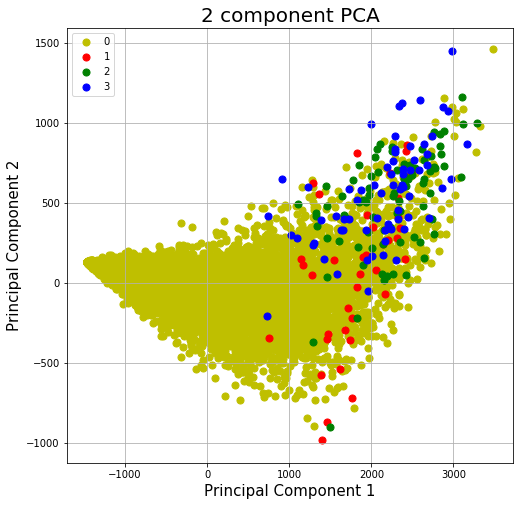

In [85]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2, 3]
colors = ['y', 'r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['targets'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
#analyse distribution of features across players (histogram)